In [1]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import LabelEncoder

import mne
from mne.decoding import (SlidingEstimator,  # GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)
from library import helpers, config

In [2]:
# %%

def load_singletrialtfr(subID, condition, pwr_style='induced', 
                        part_epo='fulllength', baseline=None, mode=None): 
    fpath = op.join(config.path_tfrs, pwr_style, 'tfr_lists', part_epo)
    fname = op.join(fpath, subID + '-collapsed-singletrialTFRs-tfr.h5')
    tfr_ = mne.time_frequency.read_tfrs(fname)
    for idx in range(len(tfr_)):
        if tfr_[idx].comment == condition:
            tfr_selection = tfr_[idx]
    
    if baseline is not None:
        tfr_selection.apply_baseline(baseline=baseline, mode=mode)
    
    return tfr_selection


def batch_trials(epos, batch_size):
    n_trials = len(epos)
    n_batches = int(n_trials / batch_size)
    rnd_seq = np.arange(n_trials)
    np.random.shuffle(rnd_seq)
    rnd_seq = rnd_seq[:n_batches * batch_size]
    rnd_seq = rnd_seq.reshape(-1, batch_size)
    batches = [epos[b].average() for b in rnd_seq]
    return(batches)



def avg_time(data, step=25, times=None):
    orig_shape = data.shape
    n_fill = step - (orig_shape[-1] % step)
    fill_shape = np.asarray(orig_shape)
    fill_shape[-1] = n_fill
    fill = np.ones(fill_shape) * np.nan
    data_f = np.concatenate([data, fill], axis=-1)
    data_res = np.nanmean(data_f.reshape(*orig_shape[:-1], -1, step), axis=-1)

    if times is not None:
        f_times = np.r_[times, [np.nan] * n_fill]
        n_times = np.nanmean(f_times.reshape(-1, step), axis=-1)
        return data_res, n_times
    else:
        return data_res


In [3]:
def get_data(subID, part_epo, signaltype, conditions, event_dict,
             batch_size=1, smooth_winsize=1):
    tfr_dict = defaultdict(dict)
    for cond in conditions:
        tfr_dict[cond] = load_singletrialtfr(subID,
                                             condition=cond,
                                             pwr_style='induced',
                                             part_epo=part_epo,
                                             baseline=None,
                                             mode=None)

        times = tfr_dict[conditions[0]].times
        freqs = tfr_dict[conditions[0]].freqs

    # Setup data:
    if batch_size > 1:
        batches = defaultdict(list)
        for cond in conditions:
            batches[cond] = batch_trials(tfr_dict[cond], batch_size)
            batches[cond] = np.asarray([b.data for b in batches[cond]])

        X = np.concatenate([batches[cond].data for cond in conditions], axis=0)
        n_ = {cond: batches[cond].shape[0] for cond in conditions}

    else:
        X = mne.concatenate_epochs([tfr_dict[cond] for cond in conditions])
        X = X.data
        n_ = {cond: len(tfr_dict[cond]) for cond in conditions}

    if smooth_winsize > 1:
        X, times_n = avg_time(X, smooth_winsize, times=times)
    else:
        times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X, y, times_n, freqs

In [4]:

def decode(sub_list_str, conditions, part_epo='fulllength', signaltype='collapsed', freqs_decod='all',
           event_dict=config.event_dict, n_rep_sub=100, shuffle_labels=False,
           batch_size=1, smooth_winsize=1, save_single_rep_scores=False,
           save_scores=True, save_patterns=False, overwrite=False):

    contrast_str = '_vs_'.join(conditions)
    scoring = 'accuracy'
    cv_folds = 5


    clf = make_pipeline(StandardScaler(),
                        LinearModel(LogisticRegression(solver='liblinear',
                                                       penalty='l2',
                                                       random_state=42,
                                                       verbose=False)))

    se = SlidingEstimator(clf,
                          scoring=scoring,
                          n_jobs=-2,
                          verbose=0)

    sub_scores = list()
    sub_scores_per_rep = list()
    sub_coef = list()
    completed_subs = list()

    for subID in sub_list_str:
        print(f'### RUNING SUBJECT {subID}')
        all_scores = list()
        all_coef = list()
        for i in np.arange(n_rep_sub):
            X_allfreqs, y, times_n, freqs = get_data(subID,
                                                    part_epo=part_epo,
                                                    signaltype=signaltype,
                                                    conditions=conditions,
                                                    event_dict=event_dict,
                                                    batch_size=batch_size,
                                                    smooth_winsize=smooth_winsize)
            if freqs_decod == 'all':
                freqs_select = freqs
            else:
                freqs_select = [f for f in freqs_decod if f in freqs]
                if len(freqs_select) < len(freqs_decod):
                    f_not_found = [f for f in freqs_decod if f not in freqs]
                    ending = 'y' if (len(f_not_found) == 1) else 'ies'
                    raise ValueError(f'Frequenc{ending} not present in data: {f_not_found}')
            if shuffle_labels:
                np.random.shuffle(y)
            for i in np.unique(y):
                print(f'Size of class {i}: {np.sum(y == i)}\n')
            
            scores_per_freq = np.zeros((len(freqs_select), len(times_n)))
            coefs_per_freq = np.zeros((len(freqs_select), X_allfreqs.shape[-3], X_allfreqs.shape[-1]))
            for idx, freq in enumerate(freqs_select):
                 print(f'#### Frequency {idx+1} from {len(freqs_select)}')
                 freq_idx = list(freqs).index(freq)
                 X = X_allfreqs[:,:,freq_idx,:]
                 scores = cross_val_multiscore(se, X=X, y=y, cv=cv_folds, verbose=0)
                 scores = np.mean(scores, axis=0)
                 scores_per_freq[idx, :] = scores

                 se.fit(X, y)
                 coef = get_coef(se, 'patterns_', inverse_transform=True)
                 coefs_per_freq[idx, :, :] = coef
                 
            all_scores.append(scores_per_freq)
            all_coef.append(coef)

        sub_scores.append(np.asarray(all_scores).mean(axis=0))
        sub_coef.append(np.asarray(all_coef).mean(axis=0))

        # save shizzle:
#         if save_single_rep_scores:
#             if len(sub_scores_per_rep) == 0:
#                 sub_scores_per_rep = np.asarray(all_scores)
#             else:
#                 sub_scores_per_rep = np.concatenate([sub_scores_per_rep,
#                                                     np.asarray(all_scores)],
#                                                     axis=0)

#             fpath = op.join(config.path_decod_temp, contrast_str, 'single_rep_data')
#             helpers.chkmk_dir(fpath)
#             fname = op.join(fpath,
#                             f'reps{n_rep_sub}_' \
#                             f'swin{smooth_winsize}_batchs{batch_size}.npy')
#             np.save(fname, sub_scores_per_rep)
#             np.save(fname[:-4] + '__times' + '.npy', times_n)
#             del(fpath, fname)
                 
        # save info:
        if (save_scores or save_patterns):
            completed_subs.append(subID)
            info_dict = {'subs': completed_subs,
                         'freqs': list(freqs),
                         'cv_folds': cv_folds, 
                         'reps': n_rep_sub,
                         'batch_size': batch_size, 
                         'smooth_winsize': smooth_winsize, 
                         'scoring': scoring}
            if len(sub_list_str) > 1:
                 sub_folder = '-'.join(sub_list_str[0], sub_list_str[-1])
            else:
                 sub_folder = sub_list_str[0]
                 
            fpath = op.join(config.path_decod_tfr, 'wavelet', part_epo, signaltype, contrast_str, sub_folder)
            if (op.exists(fpath) and not overwrite):
                path_save = op.join(config.path_decod_tfr, 'wavelet', part_epo, signaltype, contrast_str, 
                                    sub_folder + datetime_str)
            else:
                path_save = fpath
            helpers.chkmk_dir(path_save)
            fname = op.join(path_save, 'info.json')
            with open(fname, 'w+') as outfile:  
                json.dump(info_dict, outfile)
                 
                 
        # save accuracies:
        if save_scores:
            sub_scores_ = np.asarray(sub_scores)
            fpath = op.join(path_save, 'scores')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, 'scores_per_sub.npy')
            np.save(fname, sub_scores_)
            np.save(fname[:-4] + '__times' + '.npy', times_n)
            np.save(fname[:-4] + '__freqs' + '.npy', freqs_select)
            del(fpath, fname)


        # save patterns:
        if save_patterns:
            sub_patterns = np.asarray(sub_coef)
            fpath = op.join(path_save, 'patterns')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, 'patterns_per_sub.npy')
            np.save(fname, sub_patterns)
            np.save(fname[:-4] + '__times' + '.npy', times_n)
            np.save(fname[:-4] + '__freqs' + '.npy', freqs_select)
            del(fpath, fname)
                 
    return sub_scores, sub_coef, times_n, freqs


In [18]:
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

res_load = decode(sub_list_str[:1], ['LoadLowEccL', 'LoadHighEccL'], 
                  event_dict=config.event_dict, 
                  freqs_decod=[10, 12], 
                  n_rep_sub=1, 
                  batch_size=1, 
                  smooth_winsize=1,
                  overwrite=True, 
                  save_scores=True,
                  save_patterns=True)

### RUNING SUBJECT VME_S01
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S01-collapsed-singletrialTFRs-tfr.h5 ...
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S01-collapsed-singletrialTFRs-tfr.h5 ...
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata
Not setting metadata


TypeError: epochs_list[0] must be an instance of Epochs, got <class 'mne.time_frequency.tfr.EpochsTFR'>

In [ ]:
eccs = load_singletrialtfr('VME_S01', 'EccS')
eccm = load_singletrialtfr('VME_S01', 'EccM')

In [18]:
type(list(np.zeros(5)))

list

In [6]:
len(res_load)

4

In [7]:
res_load[3]

array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 22., 23., 24., 25.])

In [8]:
scor = res_load[0]

In [10]:
len(scor)

1

In [12]:
scor[0]

array([[0.42, 0.29, 0.62, 0.58, 0.47, 0.48, 0.38, 0.67, 0.71, 0.63, 0.61,
        0.39, 0.53, 0.52, 0.52, 0.62, 0.71, 0.33, 0.53, 0.29, 0.37, 0.33,
        0.44, 0.63, 0.52, 0.48, 0.64, 0.42, 0.56, 0.72, 0.66, 0.39, 0.47,
        0.57, 0.47, 0.62, 0.62, 0.28, 0.43, 0.43],
       [0.63, 0.57, 0.57, 0.52, 0.59, 0.48, 0.23, 0.48, 0.86, 0.62, 0.52,
        0.33, 0.43, 0.38, 0.62, 0.42, 0.66, 0.58, 0.51, 0.57, 0.62, 0.29,
        0.48, 0.53, 0.57, 0.44, 0.43, 0.39, 0.62, 0.77, 0.61, 0.57, 0.52,
        0.44, 0.42, 0.62, 0.61, 0.48, 0.47, 0.52]])

ValueError: x and y must have same first dimension, but have shapes (20,) and (40,)

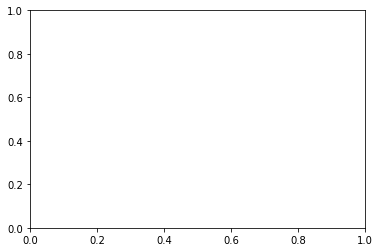

In [13]:
plt.plot(res_load[3], scor[0][0,:])

In [14]:
scor[0].shape

(2, 40)

In [15]:
res_load[2]

array([-1.351, -1.251, -1.151, -1.051, -0.951, -0.851, -0.751, -0.651,
       -0.551, -0.451, -0.351, -0.251, -0.151, -0.051,  0.049,  0.149,
        0.249,  0.349,  0.449,  0.549,  0.649,  0.749,  0.849,  0.949,
        1.049,  1.149,  1.249,  1.349,  1.449,  1.549,  1.649,  1.749,
        1.849,  1.949,  2.049,  2.149,  2.249,  2.349,  2.449,  2.5  ])

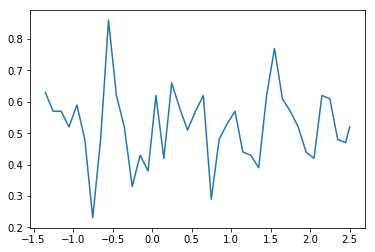

In [17]:
plt.plot(res_load[2], scor[0][1,:])